# Step25, 계산 그래프 시각화(1)

복잡한 식을 계산할 때 뒤편에서 어떤 '계산 그래프'가 만들어지는지 보기위해 시각화를 해본다.

Graphviz로 계산 그래프를 시각화해본다.

https://graphviz.gitlab.io/download/
에서 Window에서 가장 위에 stable windows 10 cmake Release x64 .........win64.exe 파일을 다운로드한다.

Add Graphviz to the system PATH for all users 체크박스에 체크하고 설치한다.

pip install GraphViz 를 터미널창에서 한다.


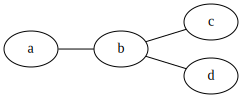

In [11]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


import graphviz 

def save_graph_as_svg(dot_string, output_file_name):
    if type(dot_string) is str:
        g = graphviz.Source(dot_string)
    elif isinstance(dot_string, (graphviz.dot.Digraph, graphviz.dot.Graph)):
        g = dot_string
    g.format='png'
    g.filename = output_file_name
    g.directory = 'markdown_img/'
    g.render(view=False)
    return g
dot_graph = """
graph graphname {
    rankdir=LR;
     a -- b -- c;
     b -- d;
}"""
save_graph_as_svg(dot_graph, 'simple_dot_example1')


## 25.3 노드에 속성 지정하기 


~~~
digraph g {
    [label="x", color=orange, style=filled]
    [label="y", color=orange, style=filled]
    [label="Exp", color=lightblue, style=filled, shape=box]
    1 -> 3
    3 -> 2
}
~~~


# Step26, 계산 그래프 시각화(2)

In [12]:
import numpy as np 
from dezero import Variable

## 26.2 계산 그래프에서 DOT 언어로 변환하기 

\_dot\_var 라는 보조 함수 구현  
밑줄(\_)이 붙은 이유 : 이 함수를 로컬에서만, 즉 get\_dot\_graph 함수 전용으로 사용할 것이기 때문 


\_dot\_var 함수에 Variable 인스턴스를 건네면 인스턴스의 내용을 DOT 언어로 작성된 문자열로 바꿔서 반환  

In [23]:
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=fileed]\n'

    name = '' if v.name is None else v.name 
    if verbose and v.data is not None:
        if v.name is not None:
            name += ': '
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)# 노드에 고유한 ID를 부여하기 위해 파이썬 내장함수인 id를 사용. 객체의 ID를 반환,객체 ID는 다른 객체와 중복 X

In [24]:
x = Variable(np.random.rand(2,3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

2287184313888 [label="x", color=orange, style=fileed]

2287184313888 [label="x: (2, 3) float64", color=orange, style=fileed]



DeZero 함수를 DOT언어로 변환하는 편의 함수를 구현 

In [25]:
def _dot_func(f):
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    txt = dot_func.format(id(f), f.__class__.__name__)

    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y()))
    return txt

In [26]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

txt = _dot_func(y.creator)
print(txt)

2287184368304 [label="Add", color=lightblue, style=filled, shape=box]
2287184368688 -> 2287184368304
2287184368832 -> 2287184368304
2287184368304 -> 2287184368112



In [27]:
def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_set = set()

    def add_func(f):
        if f not in seen_set:
            funcs.append(f)
            # funcs.sort(key=lambda x: x.generation)    # backward 메서드 구현에서 달라진 부분
            seen_set.add(f)
    
    add_func(output.creator)
    txt += _dot_var(output, verbose)

    while funcs:
        func = funcs.pop()
        txt += _dot_func(func)
        for x in func.inputs:
            txt += _dot_var(x, verbose)

            if x.creator is not None:
                add_func(x.creator)
    return 'digraph g {\n' + txt + '}'

In [28]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1 

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

txt = get_dot_graph(y, verbose=False)
print(txt)

digraph g {
2287184313456 [label="y", color=orange, style=fileed]
2287184310912 [label="Add", color=lightblue, style=filled, shape=box]
2287184312112 -> 2287184310912
2287184311248 -> 2287184310912
2287184310912 -> 2287184313456
2287184312112 [label="x0", color=orange, style=fileed]
2287184311248 [label="x1", color=orange, style=fileed]
}


## 26.3 이미지 변환까지 한번에

In [29]:
import os 
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)
    # dot 데이터를 파일에 저장 
    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')
    if not os.path.exists(tmp_dir):  # ~/.dezero 디렉터리가 없다면 새로 생성 
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

    with open(graph_path, 'w') as f:
        f.write(dot_graph)
    # dot 명령 호출 
    extension = os.path.splitext(to_file)[1][1:]    # 확장자(png, pdf 등)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)

In [30]:
def goldstein(x,y):
    z = x**2 + y**2 + 2*x*y
    return z 

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x,y)
z.backward() 

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein1.png')

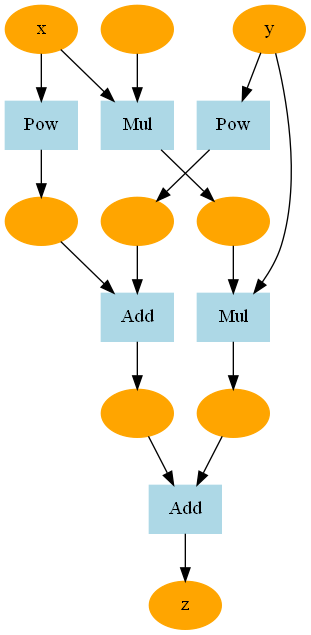

In [31]:
import numpy as np 
from dezero import Variable
from dezero.utils import plot_dot_graph

def goldstein(x,y):
    #z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
    #    (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    z = x**3 + y**3 + 2*x*y
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x,y)
z.backward() 

x.name = 'x'
y.name = 'y'
z.name = 'z'

plot_dot_graph(z, verbose=False, to_file='goldstein3.png')


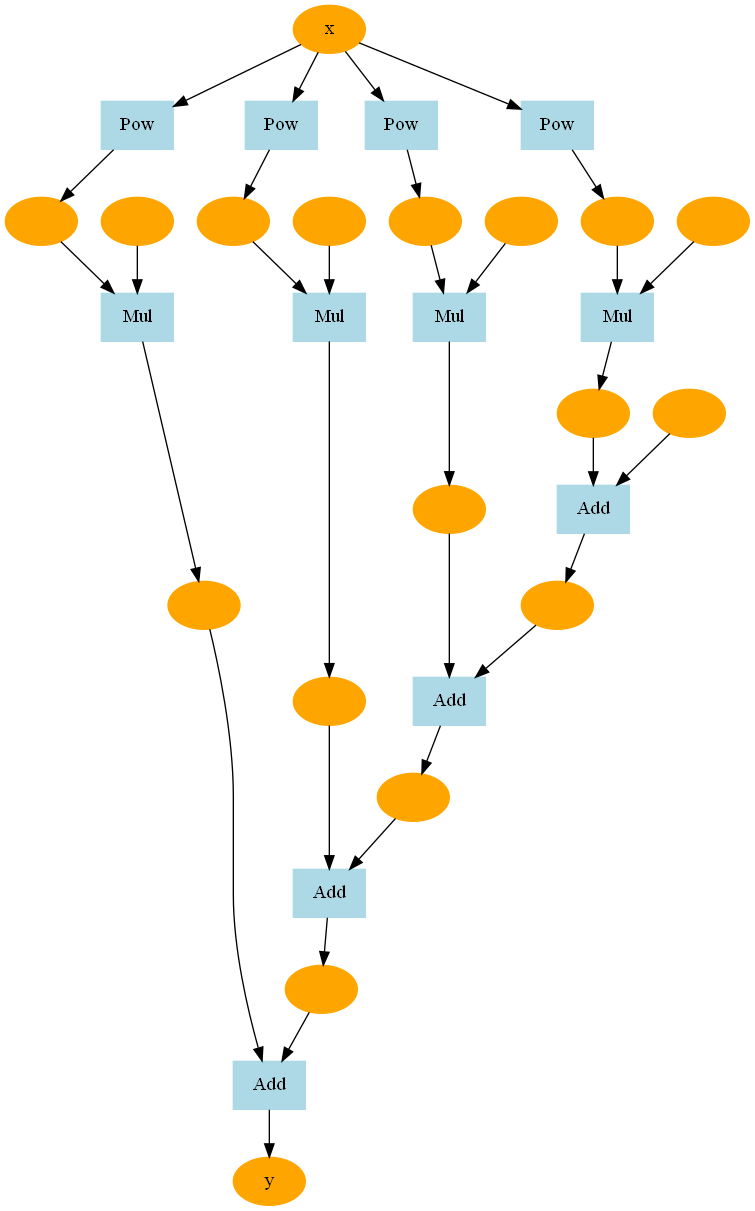

In [33]:
import math

def my_sin(x, threshold=0.001):
    y=0
    for i in range(100000):
        c = (-1)**i / math.factorial(2*i + 1)
        t = c * x**(2*i + 1)
        y = y + t 
        if abs(t.data) < threshold:
            break
    
    return y 


x = Variable(np.array(1.0))
y = my_sin(x)
y.backward() 

x.name = 'x'
y.name = 'y'

plot_dot_graph(y, verbose=False, to_file='goldstein3.png')

In [35]:
import numpy as np 
from dezero import Variable
from dezero.utils import plot_dot_graph
import math

def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=fileed]\n'

    name = '' if v.name is None else v.name 
    if verbose and v.data is not None:
        if v.name is not None:
            name += ': '
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)# 노드에 고유한 ID를 부여하기 위해 파이썬 내장함수인 id를 사용. 객체의 ID를 반환,객체 ID는 다른 객체와 중복 X

def _dot_func(f):
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    txt = dot_func.format(id(f), f.__class__.__name__)

    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y()))
    return txt


def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)
    # dot 데이터를 파일에 저장 
    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')
    if not os.path.exists(tmp_dir):  # ~/.dezero 디렉터리가 없다면 새로 생성 
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

    with open(graph_path, 'w') as f:
        f.write(dot_graph)
    # dot 명령 호출 
    extension = os.path.splitext(to_file)[1][1:]    # 확장자(png, pdf 등)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)

x = Variable(np.array(1.0))
y = my_sin(x)
y.backward() 

x.name = 'x'
y.name = 'y'

plot_dot_graph(y, verbose=False, to_file='goldstein5.png')